## Employee Burnout Prediction

#### Project Objective:
The goal of this project is to understand and observe the mental health of all the employees in one company, and predict the burnout rate of employees based on the provided features thus helping the company to take appropriate measures for their employees. 

#### Feature Summary:

* **Employee ID**: The unique ID allocated for each employee
* **Date of Joining**: The date time when the employee has joined the organization
* **Gender**: The gender of the employee (Male/Female)
* **Company Type**: The type of company where the employee is working (Service/Product)
* **WFH Setup Available**: Is the work from home facility available for the employee (Yes/No)
* **Designation**: The designation of the employee of work in the organization. 
    In the range of [0.0, 5.0] bigger is higher designation.
* **Resource Allocation**: The amount of resource allocated to the employee to work, ie. number of working hours.
    In the range of [1.0, 10.0] (higher means more resource)
* **Mental Fatigue Score**: The level of fatigue mentally the employee is facing.
    In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.
* **Burn Rate**: The value we need to predict for each employee telling the rate of Bur out while working.
    In the range of [0.0, 1.0] where the higher the value is more is the burn out.

In [86]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.sparse import hstack
from scipy.optimize import minimize
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook, tqdm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, r2_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn import metrics

#from catboost import CatBoostRegressor
#import category_encoders as ce
#import xgboost as xgb
#import lightgbm as lgb
#from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore')

In [87]:
# download dataset and saved under folder "data" in working directory
#import dataset
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample = pd.read_csv('./data/sample_submission.csv')
print('taining data shape:',train.shape)
print('test data shape:',test.shape)
print('sample data shape:',sample.shape)

taining data shape: (22750, 9)
test data shape: (12250, 8)
sample data shape: (5, 2)


### Exploratory Data Analysis

#### 1. First we look at the training data, variables format, miss values etc. 

In [88]:
# check missing values
print(" \nCount total NaN at each column in a DataFrame:\n ", train.isnull().sum())

 
Count total NaN at each column in a DataFrame:
  Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64


In [89]:
#remove missing values form last three coloms
train = train.dropna(subset=['Resource Allocation','Mental Fatigue Score','Burn Rate']).reset_index(drop=True)

In [90]:
train.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,18590.000000,18590.000000,18590.000000,18590.000000
mean,2.179398,4.486552,5.732173,0.452444
std,1.133148,2.044848,1.920547,0.197848
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.320000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


In [91]:
# sns configurations
sns.set_style(style="whitegrid")
title_font = {"family":"sans-serif", 
              "weight":"normal", 
              "color":"darkgreen", 
              "size":16}
axis_font = {"family":"serif", 
             "weight":"normal", 
             "color":"darkgreen", 
             "size":14}

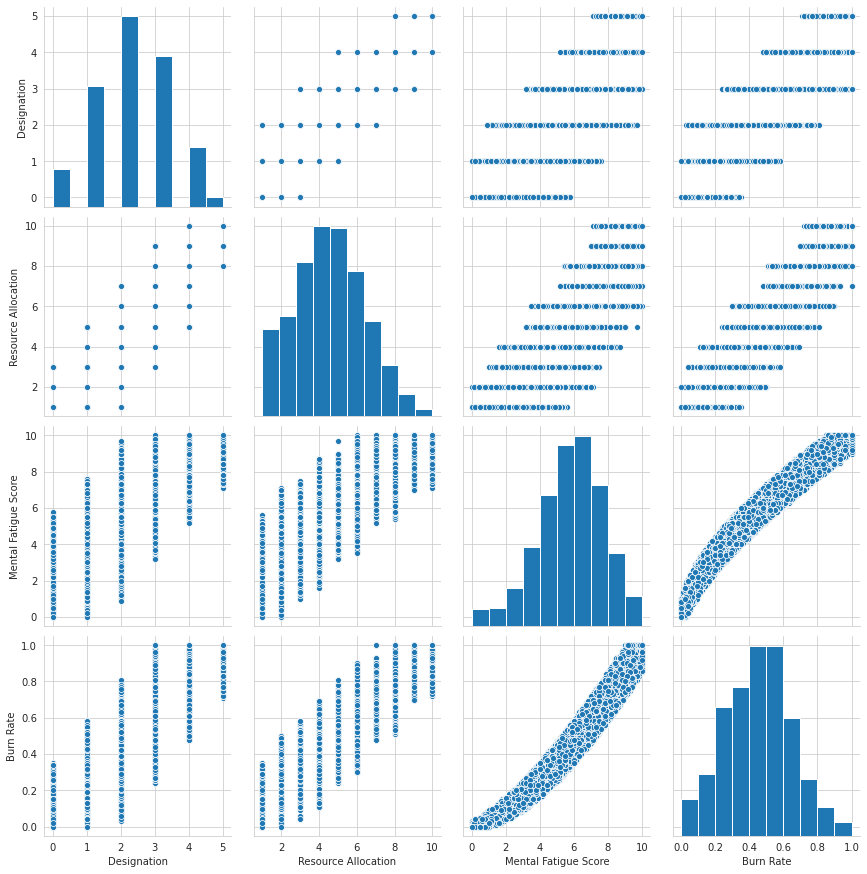

In [92]:
sns_plot = sns.pairplot(train, height=3)
sns_plot.savefig("pairplot.png")

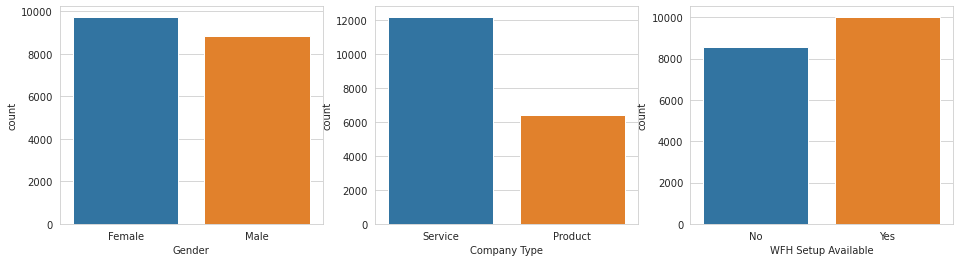

In [93]:
# visualize the categorical feature
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(16,4))
sns.countplot(train['Gender'], ax=ax[0])
sns.countplot(train['Company Type'], ax=ax[1])
sns.countplot(train['WFH Setup Available'], ax=ax[2])
fig.show()

In [94]:
train.corr()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
Designation,1.000000,0.877893,0.691823,0.736412
Resource Allocation,0.877893,1.000000,0.799563,0.855005
Mental Fatigue Score,0.691823,0.799563,1.000000,0.944389
Burn Rate,0.736412,0.855005,0.944389,1.000000


### Pre-process Data

#### 1. Transfrom categorical variables
#### 2. Format date of joining and convert the variable to senority

In [95]:
### transform 3 categorical feature

def wfh_encoder(data):
    if data["WFH Setup Available"] == "Yes":
        return 1
    return 0
def data_encoder(df):
    df["WFH Setup Available"] = df.apply(wfh_encoder, axis=1)
    df = pd.get_dummies(data=df,columns=['Gender', 'Company Type'], drop_first=True)
    return df

In [96]:
train_encoded = data_encoder(train)

In [97]:
train_encoded.head()

,Employee ID,Date of Joining,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Gender_Male,Company Type_Service
0,fffe32003000360033003200,2008-09-30,0,2.0,3.0,3.8,0.16,0,1
1,fffe3700360033003500,2008-11-30,1,1.0,2.0,5.0,0.36,1,1
2,fffe32003400380032003900,2008-11-03,1,1.0,1.0,2.6,0.20,1,1
3,fffe31003900340031003600,2008-07-24,0,3.0,7.0,6.9,0.52,0,1
4,fffe3300350037003500,2008-11-26,1,2.0,4.0,3.6,0.29,1,0


In [98]:
cols = ['WFH Setup Available','Designation','Resource Allocation',
        'Mental Fatigue Score','Burn Rate', 'Gender_Male','Company Type_Service']

### Prediction Modeling

* Baseline Model: Linear Regression

In [134]:
def eval_model(xtrain, xtest, ytrain, ytest):
    r2_train = cross_val_score(lr,xtrain,ytrain,cv=10,scoring="r2").mean()
    r2_test = cross_val_score(lr,xtest,ytest,cv=10,scoring="r2").mean()
    mse_train = abs(cross_val_score(lr,xtrain,ytrain,cv=10,scoring = "neg_mean_squared_error").mean())
    mse_test = abs(cross_val_score(lr,xtest,ytest,cv=10,scoring = "neg_mean_squared_error").mean())
    print("r2 score for train: "+str(round(100*r2_train,2))+"%")
    print("r2 score for test: "+str(round(100*r2_test,2))+"%")
    print("MSE score for train: "+str(round(100*mse_train,2))+"%")
    print("MSE score for test: "+str(round(100*mse_test,2))+"%")

In [135]:
df =train_encoded[cols]
xtrain, xtest, ytrain, ytest = train_test_split(df.loc[:, df.columns != "Burn Rate"],
                                                df.loc[:, df.columns == "Burn Rate"],
                                                test_size=0.3, random_state=88)

In [136]:
lr = LinearRegression().fit(xtrain, ytrain)
eval_model(xtrain, xtest, ytrain, ytest)

r2 score for train: 92.05%
r2 score for test: 92.0%
MSE score for train: 0.31%
MSE score for test: 0.31%


In [143]:
[*zip(xtrain.columns, lr.coef_[0])]

[('WFH Setup Available', -0.011850576812343238),
 ('Designation', -0.0041002087033785994),
 ('Resource Allocation', 0.028479189839028106),
 ('Mental Fatigue Score', 0.07381873135667098),
 ('Gender_Male', 0.0046932903050714275),
 ('Company Type_Service', 0.000725829872517908)]